In [57]:
import pandas as pd
import numpy as np

#učitavanje dataseta direktno sa GitHub-a
url = "https://raw.githubusercontent.com/jldbc/coffee-quality-database/master/data/arabica_data_cleaned.csv"
df = pd.read_csv(url)

In [38]:
#prikaz prvih 5 redova
df.head()
#osnovne informacije o kolonama
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1311 entries, 0 to 1310
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             1311 non-null   int64  
 1   Species                1311 non-null   object 
 2   Owner                  1304 non-null   object 
 3   Country.of.Origin      1310 non-null   object 
 4   Farm.Name              955 non-null    object 
 5   Lot.Number             270 non-null    object 
 6   Mill                   1001 non-null   object 
 7   ICO.Number             1163 non-null   object 
 8   Company                1102 non-null   object 
 9   Altitude               1088 non-null   object 
 10  Region                 1254 non-null   object 
 11  Producer               1081 non-null   object 
 12  Number.of.Bags         1311 non-null   int64  
 13  Bag.Weight             1311 non-null   object 
 14  In.Country.Partner     1311 non-null   object 
 15  Harv

In [39]:
#Provera nedostajućih vrednosti
df.isnull().sum()


,0
Unnamed: 0,0
Species,0
Owner,7
Country.of.Origin,1
Farm.Name,356
Lot.Number,1041
Mill,310
ICO.Number,148
Company,209
Altitude,223


In [40]:
#Pretvaranje ocena u kategorije
def oceni_kafu(score):
    if score < 80:
        return 'loša'
    elif score < 85:
        return 'srednja'
    else:
        return 'vrhunska'

df['kategorija_kvaliteta'] = df['Total.Cup.Points'].apply(oceni_kafu)
df = df.drop(columns=['Total.Cup.Points'])  # brišemo originalni score


In [41]:
#Ukloni nepotrebne kolone
kolone_za_izbacivanje = [
    'Species', 'Owner', 'Farm.Name', 'Lot.Number', 'Mill', 'ICO.Number', 'Company', 'Altitude',
    'Producer', 'Bag.Weight', 'In.Country.Partner', 'Harvest.Year', 'Grading.Date', 'Owner.1',
    'Expiration', 'Certification.Body', 'Certification.Address', 'Certification.Contact',
    'unit_of_measurement', 'Country.of.Origin'
]
df = df.drop(columns=kolone_za_izbacivanje)

In [42]:
# Transformacija tekstualnih kolona u dummies
# Grupisanje retkih regiona
top_regions = df['Region'].value_counts().nlargest(10).index
df['Region'] = df['Region'].apply(lambda x: x if x in top_regions else 'Other')

# Transformacija u dummies
df = pd.get_dummies(df, columns=['Region', 'Processing.Method', 'Variety', 'Color'], drop_first=True)


In [43]:
# Priprema ulaza i ciljne promenljive
X = df.drop(columns=['kategorija_kvaliteta'])
y = df['kategorija_kvaliteta']

In [44]:
# Skaliranje numeričkih kolona

from sklearn.preprocessing import StandardScaler


numericke_kolone = ['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 'Uniformity', 'altitude_mean_meters']
scaler = StandardScaler()
X_scaled_num = scaler.fit_transform(X[numericke_kolone])
X_scaled_num = pd.DataFrame(X_scaled_num, columns=numericke_kolone)

In [45]:
X_dummies = X.drop(columns=numericke_kolone)
X_final = pd.concat([X_scaled_num.reset_index(drop=True), X_dummies.reset_index(drop=True)], axis=1)

In [46]:
# Provera i zamena NaN vrednosti
print("NaN vrednosti pre zamene:", X_final.isna().sum().sum())
X_final = X_final.fillna(0)
print("NaN vrednosti nakon zamene:", X_final.isna().sum().sum())


NaN vrednosti pre zamene: 682
NaN vrednosti nakon zamene: 0


In [47]:
#trening i test set

from sklearn.model_selection import train_test_split

# 80% trening / 20% test
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)



In [48]:
#OneHot kodiranje y
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1))

In [49]:
#kreiranje i treniranje neuronske mreze

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#broj ulaznih osobina (broj kolona u X)

input_dim = X_train.shape[1]
#kreiranje modela


model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu'),
    layers.Dense(3, activation='softmax')
])

# Kompajliranje modela
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(X_train.shape)
print(y_train_encoded.shape)


# Treniranje modela
history = model.fit(
    X_train,
    y_train_encoded,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    verbose=1
)




(1048, 63)
(1048, 3)
Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3711 - loss: 1.3245 - val_accuracy: 0.7619 - val_loss: 0.8628
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7048 - loss: 0.7134 - val_accuracy: 0.8000 - val_loss: 0.7388
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7828 - loss: 0.5666 - val_accuracy: 0.8000 - val_loss: 0.7528
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8192 - loss: 0.4668 - val_accuracy: 0.8095 - val_loss: 0.8389
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8136 - loss: 0.4128 - val_accuracy: 0.8095 - val_loss: 0.9400
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8380 - loss: 0.4097 - val_accuracy: 0.8524 - val_loss: 1.0201
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8464 - loss: 0.3877 - val_accuracy: 0.8714 - val_loss: 1.1885
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8366 - loss: 0.3632 - val_accurac

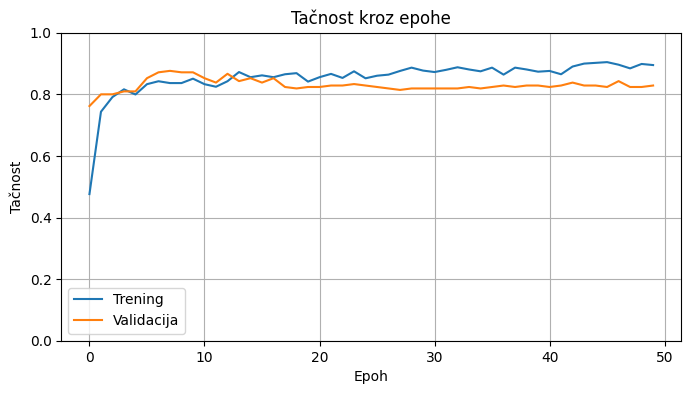

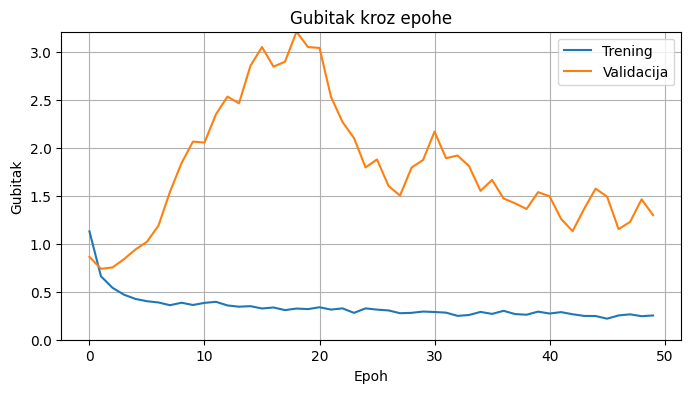

In [50]:
import matplotlib.pyplot as plt

# Tačnost
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Trening')
plt.plot(history.history['val_accuracy'], label='Validacija')
plt.title('Tačnost kroz epohe')
plt.xlabel('Epoh')
plt.ylabel('Tačnost')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()

# Gubitak
loss_values = [v for v in history.history['loss'] if not np.isnan(v)]
val_loss_values = [v for v in history.history['val_loss'] if not np.isnan(v)]

plt.figure(figsize=(8, 4))
plt.plot(loss_values, label='Trening')
plt.plot(val_loss_values, label='Validacija')
plt.title('Gubitak kroz epohe')
plt.xlabel('Epoh')
plt.ylabel('Gubitak')
plt.ylim(0, max(loss_values + val_loss_values))
plt.legend()
plt.grid(True)
plt.show()


In [56]:
# Evaluacija na test podacima
loss, accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)
print(f"Test tačnost: {accuracy:.4f}")


Test tačnost: 0.8061


In [52]:
# Predikcija za jedan primer iz X_test
import numpy as np

# Uzimamo jedan primer i pretvaramo u odgovarajući oblik
sample = X_test.iloc[0].astype('float32').to_numpy().reshape(1, -1)

# Predikcija
prediction = model.predict(sample)

# Nazivi klasa iz encoder-a
klase = encoder.categories_[0].tolist()

# Ispis predviđene klase
predicted_class = klase[np.argmax(prediction)]
print(f"Model predviđa da je kafa: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Model predviđa da je kafa: srednja


In [53]:
#cuvanje u csv file predikcije
df_rezultat = pd.DataFrame({
    'Predikcija': y_pred_classes
})
df_rezultat.to_csv("predikcije_kafe.csv", index=False)

print("Predikcije su sačuvane u predikcije_kafe.csv")

Predikcije su sačuvane u predikcije_kafe.csv


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Izveštaj klasifikacije:

              precision    recall  f1-score   support

           0       0.75      0.17      0.27        36
           1       0.82      0.98      0.89       207
           2       0.50      0.15      0.23        20

    accuracy                           0.81       263
   macro avg       0.69      0.43      0.46       263
weighted avg       0.78      0.81      0.76       263



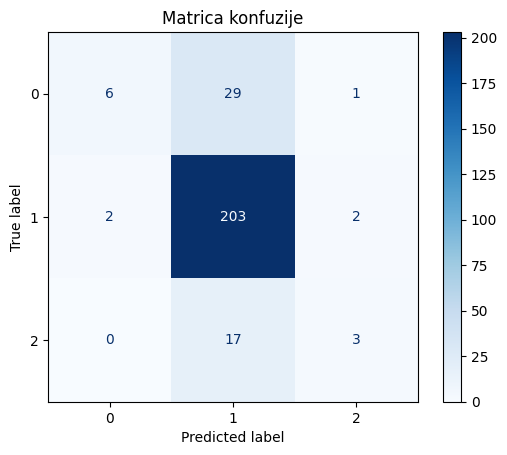

In [54]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Predikcija za ceo test skup
y_pred_probs = model.predict(X_test)

#Konverzija y_test_encoded i predikcija u klase
y_test_classes = np.argmax(y_test_encoded, axis=1)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

#Izveštaj klasifikacije
print("Izveštaj klasifikacije:\n")
print(classification_report(y_test_classes, y_pred_classes))

#Matrica konfuzije
cm = confusion_matrix(y_test_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrica konfuzije")
plt.show()


In [55]:
#cuvanje modela u .h5 formatu
model.save("model_kvalitet_kafe.h5")
print("Model sačuvan kao model_kvalitet_kafe.h5")

Model sačuvan kao model_kvalitet_kafe.h5
